## INTRODUCTION
# Connexion avec elasticsearch
dans cette partie je vais essayer d'utliser la biblitheque de elasticsearch pour me connecter et extraire les logs 




- debut du code 

Connecté à Elasticsearch
Logs filtrés: 153 logs
Logs filtrés: 12 logs
Logs filtrés: 0 logs


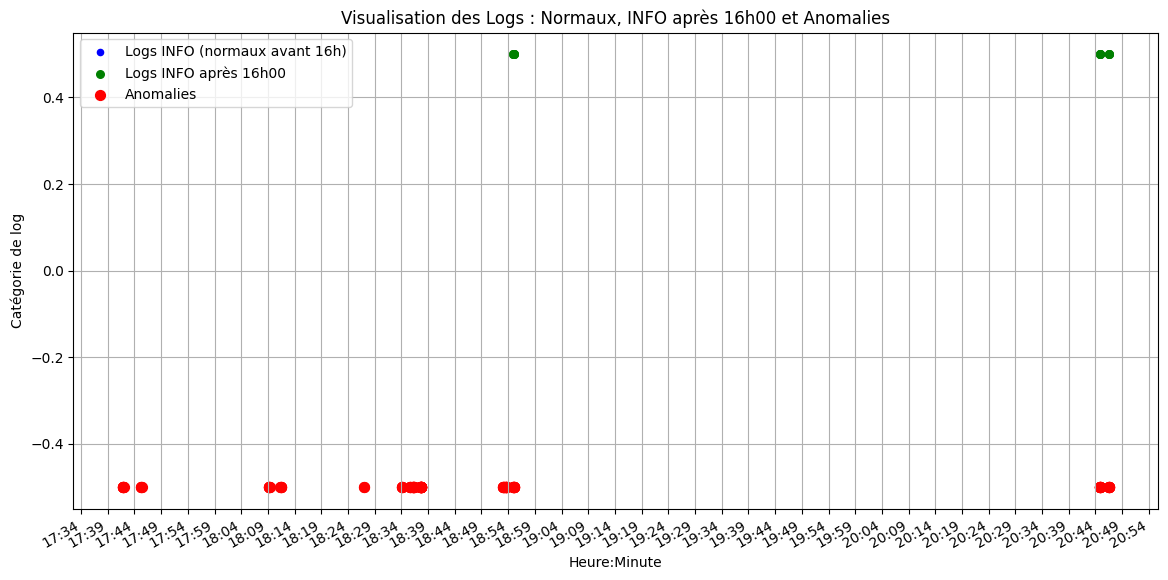

In [3]:
from elasticsearch import Elasticsearch
from datetime import datetime
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt
import matplotlib.dates as mdates  # Ajout pour le formatage de l'axe x

# Connexion à Elasticsearch
es = Elasticsearch([{'scheme': 'http', 'host': 'localhost', 'port': 9200}])

# Vérifier la connexion
if es.ping():
    print("Connecté à Elasticsearch")
else:
    print("Échec de la connexion")
    exit()

# Requête pour récupérer les logs
query = {
    "query": {"match_all": {}},
    "_source": ["host", "level", "timestamp", "logger"],
    "size": 1000
}

# Extraction des résultats
results = es.search(index="logs-2024.12.08", body=query)
logs = []

# Filtrer les logs pour vérifier la présence des informations nécessaires
for hit in results['hits']['hits']:
    log = hit['_source']
    if all(key in log for key in ['host', 'level', 'timestamp', 'logger']):
        logs.append(log)

print(f"Logs filtrés: {len(logs)} logs")

# Conversion des timestamps et extraction des données utiles
data = []
for log in logs:
    timestamp = log['timestamp']
    try:
        timestamp_dt = datetime.strptime(timestamp, "%Y-%m-%d %H:%M:%S.%f")
        host_name = log['host']['name'] if isinstance(log['host'], dict) else 'unknown'
        data.append([host_name, log['level'], log['logger'], timestamp_dt])
    except ValueError:
        continue

# Créer un DataFrame
df = pd.DataFrame(data, columns=['host', 'level', 'logger', 'timestamp_dt'])
df['time'] = df['timestamp_dt'].dt.strftime('%H:%M')  # Heure:Minute pour les graphiques

# Filtrer les logs `INFO` après 16h00
df_info_after_16 = df[(df['level'] == 'INFO') & (df['timestamp_dt'].dt.hour >= 16)]
print(f"Logs filtrés: {len(df_info_after_16)} logs")

# Filtrer les logs normaux (tous les logs INFO avant 16h)
df_normal = df[(df['level'] == 'INFO') & (df['timestamp_dt'].dt.hour < 16)]
print(f"Logs filtrés: {len(df_normal)} logs")

# Filtrer les anomalies manuelles (ERROR et FATAL)
df_anomalies = df[df['level'].isin(['ERROR', 'FATAL'])]

# Encoder les colonnes pour IsolationForest
encoder_host = LabelEncoder()
encoder_level = LabelEncoder()
encoder_logger = LabelEncoder()

df['host_encoded'] = encoder_host.fit_transform(df['host'])
df['level_encoded'] = encoder_level.fit_transform(df['level'])
df['logger_encoded'] = encoder_logger.fit_transform(df['logger'])

# Créer un DataFrame pour IsolationForest
df_numeric = df[['host_encoded', 'level_encoded', 'logger_encoded']]

# Appliquer IsolationForest pour la détection d'anomalies
iso_forest = IsolationForest(
    n_estimators=100, contamination=0.1, max_samples=min(len(df_numeric), 100), random_state=42
)
iso_forest.fit(df_numeric)

# Ajouter les résultats d'anomalie
df['anomaly_score'] = iso_forest.decision_function(df_numeric)
df['anomaly'] = iso_forest.predict(df_numeric)

# Correction pour forcer ERROR et FATAL comme anomalies
df.loc[df['level'].isin(['ERROR', 'FATAL']), 'anomaly'] = -1


# Trier les DataFrames pour ordonner les temps
df = df.sort_values(by='timestamp_dt')
df_normal = df_normal.sort_values(by='timestamp_dt')
df_info_after_16 = df_info_after_16.sort_values(by='timestamp_dt')
df_anomalies = df_anomalies.sort_values(by='timestamp_dt')

# Graphique combiné
plt.figure(figsize=(14, 7))

# Afficher les logs normaux (INFO avant 16h) en bleu
plt.scatter(
    df_normal['timestamp_dt'], [0] * len(df_normal),
    color='blue', label='Logs INFO (normaux avant 16h)', s=20
)

# Afficher les logs INFO après 16h00 en vert
plt.scatter(
    df_info_after_16['timestamp_dt'], [0.5] * len(df_info_after_16),
    color='green', label='Logs INFO après 16h00', s=30
)

# Afficher les anomalies (ERROR et FATAL) en rouge
plt.scatter(
    df_anomalies['timestamp_dt'], [-0.5] * len(df_anomalies),
    color='red', label='Anomalies', s=50
)

# Formatage de l'axe des x
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))  # Affiche Heure:Minute
plt.gca().xaxis.set_major_locator(mdates.MinuteLocator(interval=5))  # Intervalles de 5 minutes
plt.gcf().autofmt_xdate()  # Rotation automatique des dates pour éviter les chevauchements

plt.title("Visualisation des Logs : Normaux, INFO après 16h00 et Anomalies")
plt.xlabel("Heure:Minute")
plt.ylabel("Catégorie de log")
plt.legend()
plt.grid(True)
plt.show()
